<a href="https://colab.research.google.com/github/SLMath/DS_PlanoSaude-Pycaret/blob/main/Health_Insurance_Cost_ML_Pycaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#FF8080">Aviso: o código demora cerca de 40 minutos para conclusão, e é necessário confirmar o tipo das variáveis após a chamada da função setup</font>



# OBJETIVO: predição do gasto do plano de saúde com um novo cliente

### Baseado em dados colhidos de clientes anteriores, definir um modelo preditivo para o gasto do plano de saúde.

Vou explorar a biblioteca `pycaret` para treinar e comparar diferentes modelos.
Esta lib disponibiliza datasets para analise assim como muitas ferramentas de Machine Learning.

In [14]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Preparar Dados

Carregando dados sobre os gastos de um seguro com uma pessoa descrita por:
- idade,
- sexo,
- indice de massa corporal,
- se é fumante,
- localização

In [15]:
from pycaret.datasets import get_data

insurance_data = get_data('insurance', verbose= False)
insurance_data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Configurando a lib para tratar os dados conforme desejado

In [16]:
from pycaret.regression import setup

data_setup = setup(
    data= insurance_data,      # all data set: training and testinng
    target= 'charges',         # label: which field is the outcome
    normalize= True,           # applying statistics to reduce the numerical features range
    remove_outliers= True      # ignore sample which is statistically too far from the others
    #verbose= False
)

,Description,Value
0,Session id,4784
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1338, 7)"
4,Transformed data shape,"(1291, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(402, 10)"
7,Ordinal features,2
8,Numeric features,3
9,Categorical features,3


# Treinar um Primeiro Modelo

Exibe os índices de performance para os 10 folders (default do setup) que são conjunto de dados para treinamento usados para diminuir a variância do treinamento.

In [17]:
from pycaret.regression import create_model

rf_model = create_model('rf') # Random Forest

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2284.8973,14873632.3814,3856.6349,0.9242,0.3945,0.2661
1,2658.0294,21206916.6413,4605.0968,0.8191,0.4345,0.3093
2,3083.5970,33858714.1306,5818.8241,0.7796,0.4697,0.3180
3,3008.4458,32636819.2030,5712.8644,0.7340,0.4891,0.3195
4,1977.0809,8301259.9389,2881.1907,0.9497,0.3844,0.3190
5,2601.7672,26814233.5241,5178.2462,0.7842,0.4554,0.2071
6,2230.2969,15794434.9908,3974.2213,0.8859,0.4228,0.3289
7,2979.2867,24375936.8617,4937.1993,0.8327,0.5097,0.3782
8,3106.1455,30038007.8731,5480.6941,0.7696,0.5274,0.3290


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [20]:
mean_charges = insurance_data['charges'].mean()
print(f'média de gastos: ${mean_charges:.2f}')

value_RMSE = 4658.7458
print(f'desvio percentual: {value_RMSE / mean_charges:.1%}')

média de gastos: $13270.42
desvio percentual: 35.1%


O desvio(erro) é muito alto em comparação com a média. Então tentamos diminuir esse valor treinando o modelo para otimizar o valor de RMSE.

In [21]:
from pycaret.regression import tune_model

print('Aplicando 20 Iterações')
rf_model_trained20 = tune_model(rf_model, optimize="RMSE", n_iter=20)

print()
print('Aplicando 40 Iterações')
rf_model_trained40 = tune_model(rf_model, optimize="RMSE", n_iter=40)

Aplicando 20 Iterações


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1923.6914,10373837.9085,3220.8443,0.9471,0.3347,0.2117
1,2603.9251,19924671.5647,4463.7060,0.8300,0.4093,0.3068
2,2887.2906,31564882.5052,5618.2633,0.7946,0.4486,0.2900
3,2778.2449,28936176.2444,5379.2357,0.7642,0.4428,0.2880
4,1751.2816,6048557.9606,2459.3816,0.9634,0.3471,0.2878
5,2542.8306,24981309.9705,4998.1306,0.7990,0.4262,0.2109
6,2141.9283,14635609.9004,3825.6516,0.8942,0.3681,0.2775
7,2584.7322,18968860.4394,4355.3255,0.8698,0.4569,0.3187
8,2998.4915,25894528.5415,5088.6667,0.8013,0.5019,0.3206


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 20 candidates, totalling 200 fits



Aplicando 40 Iterações


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1930.4551,10308505.5468,3210.6861,0.9475,0.3325,0.2138
1,2611.3193,19683985.8069,4436.6638,0.8321,0.4075,0.3095
2,2908.1615,31806667.1913,5639.7400,0.7930,0.4521,0.2950
3,2792.1652,28839958.9372,5370.2848,0.7650,0.4461,0.2974
4,1763.2653,6059884.8088,2461.6833,0.9633,0.3475,0.2908
5,2545.7969,24966306.6825,4996.6295,0.7991,0.4256,0.2114
6,2161.7944,14543272.5694,3813.5643,0.8949,0.3698,0.2826
7,2578.3763,18937796.2569,4351.7578,0.8700,0.4615,0.3217
8,2977.8851,25582517.6715,5057.9163,0.8037,0.4974,0.3186


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 40 candidates, totalling 400 fits


RMSE caiu para próximo a 4355 com 20 iterações e 4347 com 40.

In [23]:
value_RMSE20 = 4355
print(f'deviation for 20 iterations: {value_RMSE20 / mean_charges:.1%}')
print()

value_RMSE40 = 4347
print(f'deviation for 40 iterations: {value_RMSE40 / mean_charges:.1%}')

deviation for 20 iterations: 32.8%

deviation for 40 iterations: 32.8%


Os desvios percentuais ainda estão muito altos, porém é visível que há uma queda (otimização) entre as interações.

# Análise Exploratória das entradas (features)

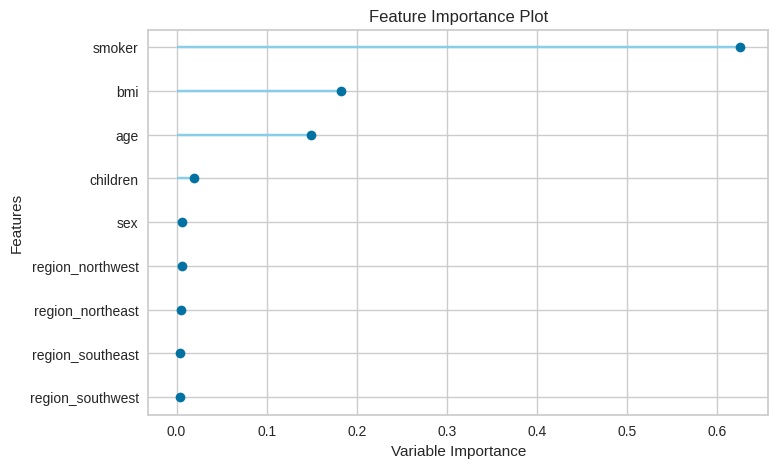

In [24]:
from pycaret.regression import plot_model

plot_model(rf_model, plot= 'feature')

Observa-se claramente por esse gráfico que há
- forte influência quanto ao fato de ser fumante ou não,
- média influência do índice de massa corporal e da idade
- pouquíssima influência do restante.

# Comparando diferente modelos

Seleciona os 3 modelos com melhor performance inicial do índice RMSE

In [25]:
from pycaret.regression import compare_models

best_models_RMSE = compare_models(sort= "RMSE", n_select= 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2449.0642,20648730.1991,4451.1155,0.8513,0.4077,0.2797,0.5180
lightgbm,Light Gradient Boosting Machine,2685.8528,21682871.5644,4567.2468,0.8444,0.5260,0.3310,0.7360
rf,Random Forest Regressor,2589.8909,22506015.1913,4658.7458,0.8389,0.4340,0.2964,0.3570
et,Extra Trees Regressor,2625.4689,25496516.5575,4983.6917,0.8178,0.4547,0.2961,0.6010
xgboost,Extreme Gradient Boosting,2919.3261,26237486.6000,5039.7544,0.8113,0.4908,0.3517,0.3700
ada,AdaBoost Regressor,4601.8624,30611010.4804,5478.5297,0.7810,0.6653,0.8249,0.5290
knn,K Neighbors Regressor,3420.4416,32630226.4000,5680.9460,0.7716,0.4627,0.3362,0.2680
lar,Least Angle Regression,3974.3266,35829776.6422,5964.1527,0.7500,0.5414,0.3745,0.2670
lasso,Lasso Regression,3974.1803,35830247.4453,5964.1936,0.7500,0.5326,0.3745,0.2610
llar,Lasso Least Angle Regression,3974.1767,35830391.8892,5964.2063,0.7500,0.5328,0.3745,0.2720


Processing:   0%|          | 0/83 [00:00<?, ?it/s]

Treinamento de todos os modelos selecionados e mesclagem dos modelos para aperfeiçoamento.
A escolha de 100 interações faz o processamento ser bem lento, porém garante um melor aperfeiçoamento.

In [26]:
from pycaret.regression import blend_models

best_models_trained = [
    tune_model(model, optimize= "RMSE", n_iter= 100, verbose= False)
    for model in best_models_RMSE
]
best_models_blended = blend_models(best_models_trained)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1639.5639,9163899.8930,3027.1934,0.9533,0.2974,0.1577
1,2294.1435,19896329.0865,4460.5301,0.8303,0.4052,0.2519
2,2492.1316,29576890.0518,5438.4639,0.8075,0.4107,0.2258
3,2590.2974,29494234.7468,5430.8595,0.7596,0.4349,0.2423
4,1442.3226,4803132.2364,2191.6049,0.9709,0.2955,0.2217
5,2287.3805,23835780.0822,4882.1901,0.8082,0.4074,0.1747
6,1976.1124,14138841.7047,3760.1651,0.8978,0.3479,0.2358
7,2232.6746,18293835.4982,4277.1294,0.8744,0.4086,0.2291
8,2642.4208,22975108.9376,4793.2357,0.8237,0.4775,0.2674


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Mesmo procurando uma melhor otimização, no fim a mistura resultou num ínidice de 4262, valor muito próximo ao random forest anterior com 40 interações, considerando os desvios padrão.

# Testando o Modelo

In [29]:
from pycaret.regression import predict_model

prediction = predict_model(best_models_blended)
prediction

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2466.5537,24091921.2753,4908.3522,0.8261,0.4253,0.2360


,age,sex,bmi,children,smoker,region,charges,prediction_label
117,29,female,27.940001,1,yes,southeast,19107.779297,19867.838743
385,19,male,34.400002,0,no,southwest,1261.859009,1529.183053
1299,19,female,25.745001,1,no,northwest,2710.828613,3923.112870
1120,23,female,31.400000,0,yes,southwest,34166.273438,35493.854299
16,52,female,30.780001,1,no,northeast,10797.335938,12292.983795
...,...,...,...,...,...,...,...,...
1097,22,male,33.770000,0,no,southeast,1674.632324,2390.168870
1258,55,male,37.715000,3,no,northwest,30063.580078,14177.022293
518,35,female,31.000000,1,no,southwest,5240.765137,5229.626326
366,56,female,32.299999,3,no,northeast,13430.264648,13433.428172


In [30]:
print('Exibindo erros absolutos por amostras')
error = prediction['prediction_label'] - prediction['charges']
display(error)

Exibindo erros absolutos por amostras


117       760.059447
385       267.324044
1299     1212.284256
1120     1327.580861
16       1495.647857
            ...     
1097      715.536546
1258   -15886.557785
518       -11.138810
366         3.163523
804      2319.904104
Length: 402, dtype: float64

Os testes sobre os dados separados do treinamento resultaram em um índice de RMSE de aproximadamente 4908, um valor próximo a amostra de treinamento, o que é um bom indício de que o treinamento não sofreu overfitting ou alguma outra deturpação.

Esse modelo treinado é então salvo para posterior utilização.

# Salvar Modelo

In [31]:
from pycaret.regression import finalize_model, save_model

final_model = finalize_model(best_models_blended)
save_model(best_models_blended, "insurance-cost-prediction-model", verbose= False)

(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['age', 'bmi', 'children'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['sex', 'smoker', 'region'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['sex', 'smoker...
                                                             learning_rate=0.05,
                                                             min_child_samples=41,
                                                             min_split_gain=0.7,
                                                             n_estimators=190,
                                                             num_leaves=40,
                                                            

# Previsão de gastos utilizando o novo modelo

In [35]:
import pandas as pd
from pycaret.regression import load_model
from typing import List, Any, Callable

cost_prediction_model = load_model("insurance-cost-prediction-model", verbose= False)

# random default parameters just because some value is needed
def predict_total_cost(
    age = 35,
    sex = 'female',
    bmi = 25,
    children = 2,
    smoker = 'no',
    region = 'south'
):
    # create a pandas dataframe
    input = {
        'age': [age],
        'sex': [sex],
        'bmi': [bmi],
        'children': [children],
        'smoker': [smoker],
        'region': [region]
    }
    input_df = pd.DataFrame(input)

    # apply the saved module to predict the cost for a new client
    return float(predict_model(cost_prediction_model, data= input_df)['prediction_label'].round(2))

def compute_influence_by_feature(
    name: str,
    values: List[Any],
    predict_cost_by_one_param: Callable[[Any], Any],
    display_influence_tables: bool = True
):
    # compute cost value for each tested feature
    influence_df = pd.DataFrame(data= values, columns= [name]);
    influence_df['custo'] = [
        predict_cost_by_one_param(value)
        for value in influence_df[name]
    ]

    # display table to visually avaliate the test
    if display_influence_tables:
        display(influence_df)

    # return the standard deviation for the test
    return influence_df.std(0)['custo']

Análise da variação dos valores previstos alterando uma das entradas por vez.

In [36]:
all_influence = {}
display_influence_tables = True

In [37]:
all_influence['smoker'] = compute_influence_by_feature(
    'smoker',
    ['no', 'yes'],
    lambda value: predict_total_cost(smoker= value),
    display_influence_tables
)

,smoker,custo
0,no,6043.64
1,yes,19327.66


In [38]:
all_influence['age'] = compute_influence_by_feature(
    'age',
    range(5, 80, 5),
    lambda value: predict_total_cost(age= value),
    display_influence_tables
)

,age,custo
0,5,4695.22
1,10,4695.22
2,15,4695.22
3,20,5070.21
4,25,5793.35
5,30,5376.41
6,35,6043.64
7,40,7761.90
8,45,9427.77
9,50,11424.85


In [39]:
all_influence['sex'] = compute_influence_by_feature(
    'sex',
    ['male', 'female'],
    lambda value: predict_total_cost(sex= value),
    display_influence_tables
)

,sex,custo
0,male,5708.02
1,female,6043.64


In [40]:
all_influence['bmi'] = compute_influence_by_feature(
    'bmi',
    range(10, 58, 3),
    lambda value: predict_total_cost(bmi= value),
    display_influence_tables
)

,bmi,custo
0,10,6111.97
1,13,6111.97
2,16,6111.97
3,19,6111.97
4,22,5914.67
5,25,6043.64
6,28,6316.28
7,31,6096.59
8,34,6462.63
9,37,7272.15


In [41]:
all_influence['children'] = compute_influence_by_feature(
    'children',
    range(0, 6, 1),
    lambda value: predict_total_cost(children= value),
    display_influence_tables
)

,children,custo
0,0,5115.36
1,1,5685.03
2,2,6043.64
3,3,6277.35
4,4,6810.24
5,5,6810.24


In [42]:
all_influence['region'] = compute_influence_by_feature(
    'region',
    ['south', 'north', 'east', 'west', 'southeast', 'southwest', 'northeast', 'northwest' ],
    lambda value: predict_total_cost(region= value),
    display_influence_tables
)

,region,custo
0,south,6043.64
1,north,6043.64
2,east,6043.64
3,west,6043.64
4,southeast,5867.05
5,southwest,5656.47
6,northeast,6189.98
7,northwest,6317.58


In [43]:
abs_influence_col = 'influence measured by std dev'

all_influence_df = pd.DataFrame(
    index= all_influence.keys(), # features
    data= all_influence.values(), # std dev of the predicted cost
    columns= [abs_influence_col]);

all_influence_df[abs_influence_col] = all_influence_df[abs_influence_col].astype(int)

min_influence_score = all_influence_df[abs_influence_col].min()
all_influence_df['relative influence'] = [
    f'x {val / min_influence_score:.2f}'
    for val in all_influence_df[abs_influence_col]
]

display(all_influence_df.sort_values(by= abs_influence_col, ascending= False))

,influence measured by std dev,relative influence
smoker,9393,x 47.44
age,4767,x 24.08
children,660,x 3.33
bmi,441,x 2.23
sex,237,x 1.20
region,198,x 1.00


# Conclusão

Concluindo dessa análise, os fatores mais relevantes para determinação do custo são
- se fumante
- idade do avaliado.

Essa é apenas uma métrica e seria adequado analisar outras para fazer uma composição de resultados, porém ela já evidencia a grande influência do tabagismo nos custos do o plano de saúde e também uma forte influência da idade, que, como imaginado, é um relação direta: quanto mais velho, maior o gasto.